In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN

from acquire import get_zillow_data
from summarize import df_summary
import prepare
import explore
import model
import features

seed = 123

In [2]:
df = get_zillow_data()

In [3]:
df_summary(df)

--- Shape: (85224, 60)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85224 entries, 0 to 85223
Data columns (total 60 columns):
id                              85224 non-null int64
parcelid                        85224 non-null int64
airconditioningtypeid           28311 non-null float64
architecturalstyletypeid        261 non-null float64
basementsqft                    42 non-null float64
bathroomcnt                     85224 non-null float64
bedroomcnt                      85224 non-null float64
buildingclasstypeid             0 non-null object
buildingqualitytypeid           53810 non-null float64
calculatedbathnbr               85207 non-null float64
decktypeid                      654 non-null float64
finishedfloor1squarefeet        6821 non-null float64
calculatedfinishedsquarefeet    85224 non-null float64
finishedsquarefeet12            85035 non-null float64
finishedsquarefeet13            2 non-null float64
finishedsquarefeet15            29 non-null float64
fin

   num_cols_missing    pct_cols_missing  num_rows
0                19  31.666666666666664         2
1                20   33.33333333333333        14
2                21                35.0        79
3                22  36.666666666666664       271
4                23  38.333333333333336       584
5                24                40.0       713
6                25   41.66666666666667      6524
7                26  43.333333333333336      8779
8                27                45.0     13750
9                28  46.666666666666664     23399
10               29  48.333333333333336     17257
11               30                50.0      6973
12               31   51.66666666666667      4027
13               32  53.333333333333336      2401
14               33   55.00000000000001       240
15               34  56.666666666666664       202
16               35  58.333333333333336         5
17               36                60.0         2
18               37   61.66666666666667         2


In [4]:
df.unitcnt.value_counts(dropna=False)

 1.0    54142
NaN     31082
Name: unitcnt, dtype: int64

Look at the columns that have plenty of non-null values but we don't want to use in the first iteration.  (based on domain knowledge of housing prices and other fields available). I am not including those that are mostly null because they will be addressed when we remove columns with majority nulls. 

In [5]:
rmv_cols = ['id', 'architecturalstyletypeid', 'assessmentyear', 'buildingclasstypeid', 'buildingqualitytypeid', 
            'calculatedbathnbr', 'censustractandblock', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 
            'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc',
            'rawcensustractandblock', 'regionidneighborhood', 'regionidcity', 'regionidzip', 'taxvaluedollarcnt', 
            'taxamount', 'unitcnt']
df = prepare.data_prep(df, cols_to_remove=rmv_cols, prop_required_column=.5, prop_required_row=.75)

In [8]:
df_summary(df)

--- Shape: (85223, 13)
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85223 entries, 0 to 85223
Data columns (total 13 columns):
parcelid                        85223 non-null int64
bathroomcnt                     85223 non-null float64
bedroomcnt                      85223 non-null float64
calculatedfinishedsquarefeet    85223 non-null float64
latitude                        85223 non-null float64
longitude                       85223 non-null float64
lotsizesquarefeet               85223 non-null float64
regionidcounty                  85223 non-null float64
roomcnt                         85223 non-null float64
yearbuilt                       85223 non-null float64
structuretaxvaluedollarcnt      85223 non-null float64
landtaxvaluedollarcnt           85223 non-null float64
logerror                        85223 non-null float64
dtypes: float64(12), int64(1)
memory usage: 9.1 MB
--- Descriptions
           parcelid   bathroomcnt    bedroomcnt  calculatedfinishedsquarefeet 

**Notes:**
- drop remaining null values
- drop roomcnt:  values are mostly 0's
- Data types that are numeric but represent categories
- convert yearbuild to age
- outliers in bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, lotsizesquarefeet, structuretaxvaluedollarcnt, landtaxvaluedollarcnt

In [7]:
# drop the 1 row that has a missing value in landtaxvaluedollarcnt
df = df[pd.notna(df.landtaxvaluedollarcnt)]

# fill land square feet with median value
df.fillna(df.median(), inplace=True)

In [9]:
df = df.drop(columns = ['roomcnt'])

Data Types: change regionidcounty to category

In [10]:
num_to_cat = ['regionidcounty']

df = prepare.numeric_to_category(df, num_to_cat)

Convert yearbuilt to age

In [11]:
df['age'] = (2019 - df.yearbuilt)
df.drop(columns=['yearbuilt'], inplace=True)

In [12]:
df.describe(include='all')

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcounty,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,logerror,age
count,8.522300e+04,85223.000000,85223.000000,85223.000000,8.522300e+04,8.522300e+04,8.522300e+04,85223.0,8.522300e+04,8.522300e+04,85223.000000,85223.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3101.0,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54316.0,NaN,NaN,NaN,NaN
mean,1.301329e+07,2.281421,3.018551,1749.333854,3.400504e+07,-1.181953e+08,2.709239e+04,NaN,1.810069e+05,2.792165e+05,0.011447,49.244594
std,2.551612e+06,0.937197,0.991395,908.471282,2.683113e+05,3.645526e+05,1.141685e+05,NaN,2.101957e+05,4.016750e+05,0.153722,23.059027
min,1.071174e+07,1.000000,1.000000,501.000000,3.333930e+07,-1.194479e+08,1.670000e+02,NaN,1.000000e+02,2.200000e+01,-4.605000,4.000000
25%,1.154009e+07,2.000000,2.000000,1175.000000,3.380585e+07,-1.184172e+08,5.999000e+03,NaN,8.199950e+04,8.219650e+04,-0.024300,32.000000
50%,1.260033e+07,2.000000,3.000000,1520.000000,3.402135e+07,-1.181613e+08,7.232000e+03,NaN,1.325655e+05,1.943450e+05,0.006000,48.000000
75%,1.426052e+07,3.000000,4.000000,2058.000000,3.417540e+07,-1.179114e+08,1.062600e+04,NaN,2.109235e+05,3.471515e+05,0.037300,65.000000


New Features

In [13]:
df = features.new_features(df)

In [14]:
df = features.bin_feature(df, col='bathroomcnt', newcol='bathbin',
                         bin_cuts=[0,1.5,2,3.5,5,20])
df.bathbin.value_counts(sort=False)

1    16263
2    35056
3    28343
4     4673
5      888
Name: bathbin, dtype: int64

In [19]:
df = features.bin_feature(df, col='bedroomcnt', newcol='bedbin', 
                         bin_cuts=[0,1,2,3,5,20])
df.bedbin.value_counts(sort=False)

1     3745
2    22006
3    34877
4    23749
5      846
Name: bedbin, dtype: int64

In [20]:
df = features.bin_feature(df, col='bedandbath', newcol='bedbathbin', 
                          bin_cuts=[1,2,3,4,5,6,7.5,11,25])
df.bedbathbin.value_counts(sort=False, dropna=False)

1     3108
2     7607
3    15213
4    22224
5    18412
6    11634
7     6616
8      409
Name: bedbathbin, dtype: int64

In [21]:
df = features.bin_feature(df, col='age', newcol='agebin', 
                          bin_cuts=[0,10,20,30,45,60,75,95,135])
df.agebin.value_counts(sort=False)

1     1769
2     9005
3     8781
4    19506
5    17682
6    18631
7     7017
8     2832
Name: agebin, dtype: int64

In [22]:
df = features.bin_feature(df, col='logerror', newcol='errorbin', 
                          bin_cuts=[-5,0,.5,.8,.9,.95,1,1.05,1.1,1.2,2,6])
df.errorbin.value_counts(sort=False)

1       100
2       274
3      1488
4      3439
5      7013
6     25793
7     30687
8      8943
9      4450
10     2848
11      188
Name: errorbin, dtype: int64

In [23]:
df = features.bin_feature(df, col='livingsqft', newcol='sqftbin', 
                          bin_cuts=[100,600,1000,1600,2100,2600,
                                   3600,5500,20000])
df.sqftbin.value_counts(sort=False)

1     6004
2    29293
3    29196
4    10136
5     4985
6     3882
7     1383
8      344
Name: sqftbin, dtype: int64

In [24]:
df = features.bin_feature(df, col='acres', newcol='lotbin', 
                          bin_cuts=[0,.1,.15,.2,.3,.5,1,5,10,20,160])
df.lotbin.value_counts(sort=False)

1      8166
2     21440
3     28744
4      9160
5      5515
6      4120
7      5969
8      1286
9       655
10      161
Name: lotbin, dtype: int64

In [25]:
df = features.bin_feature(df, col='taxvalue', newcol='valuebin', 
                          bin_cuts=[50000, 100000, 200000, 300000, 
                                    400000, 500000, 600000, 700000, 
                                    1000000, 2000000, 3000000])

df.valuebin.value_counts(sort=False)

1      6793
2     12525
3     14875
4     13998
5     10668
6      6862
7      4772
8      6873
9      4553
10      877
Name: valuebin, dtype: int64

In [ ]:
df = features.bin_feature(df, col='structure_dollarpersqft', 
                          newcol='dollarpersqft_structure_bin',
                          bin_cuts=[50,100,150,200,300,400,1500])
df.dollarpersqft_structure_bin.value_counts(sort=False, dropna=False)

In [27]:
df = features.bin_feature(df, col='land_dollarpersqft', 
                          newcol='dollarpersqft_land_bin',
                          bin_cuts=[0,1,25,50,100,150,200,250,350,500,2500])
df.dollarpersqft_land_bin.value_counts(sort=False)

1      4748
2     38321
3     21237
4     14170
5      3575
6      1467
7       692
8       585
9       235
10      193
Name: dollarpersqft_land_bin, dtype: int64

In [28]:
df.drop(columns=['bathroomcnt','bedroomcnt',
                'calculatedfinishedsquarefeet','lotsizesquarefeet',
                'structuretaxvaluedollarcnt','landtaxvaluedollarcnt',
                'age','bedandbath','structure_dollarpersqft', 
                'land_dollarpersqft','acres','livingsqft','taxvalue'],
       inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85223 entries, 0 to 85223
Data columns (total 15 columns):
parcelid                       85223 non-null int64
latitude                       85223 non-null float64
longitude                      85223 non-null float64
regionidcounty                 85223 non-null category
logerror                       85223 non-null float64
bathbin                        85223 non-null category
bedbin                         85223 non-null category
bedbathbin                     85223 non-null category
agebin                         85223 non-null category
errorbin                       85223 non-null category
sqftbin                        85223 non-null category
lotbin                         85216 non-null category
valuebin                       82796 non-null category
dollarpersqft_structure_bin    70279 non-null category
dollarpersqft_land_bin         85223 non-null category
dtypes: category(11), float64(3), int64(1)
memory usage: 4.1 MB


In [31]:
df.dropna(inplace=True)

In [32]:
cols_to_int = df.drop(columns=['regionidcounty']).select_dtypes(include='category').columns
for col in cols_to_int:
    df[col] = df[col].astype(int)

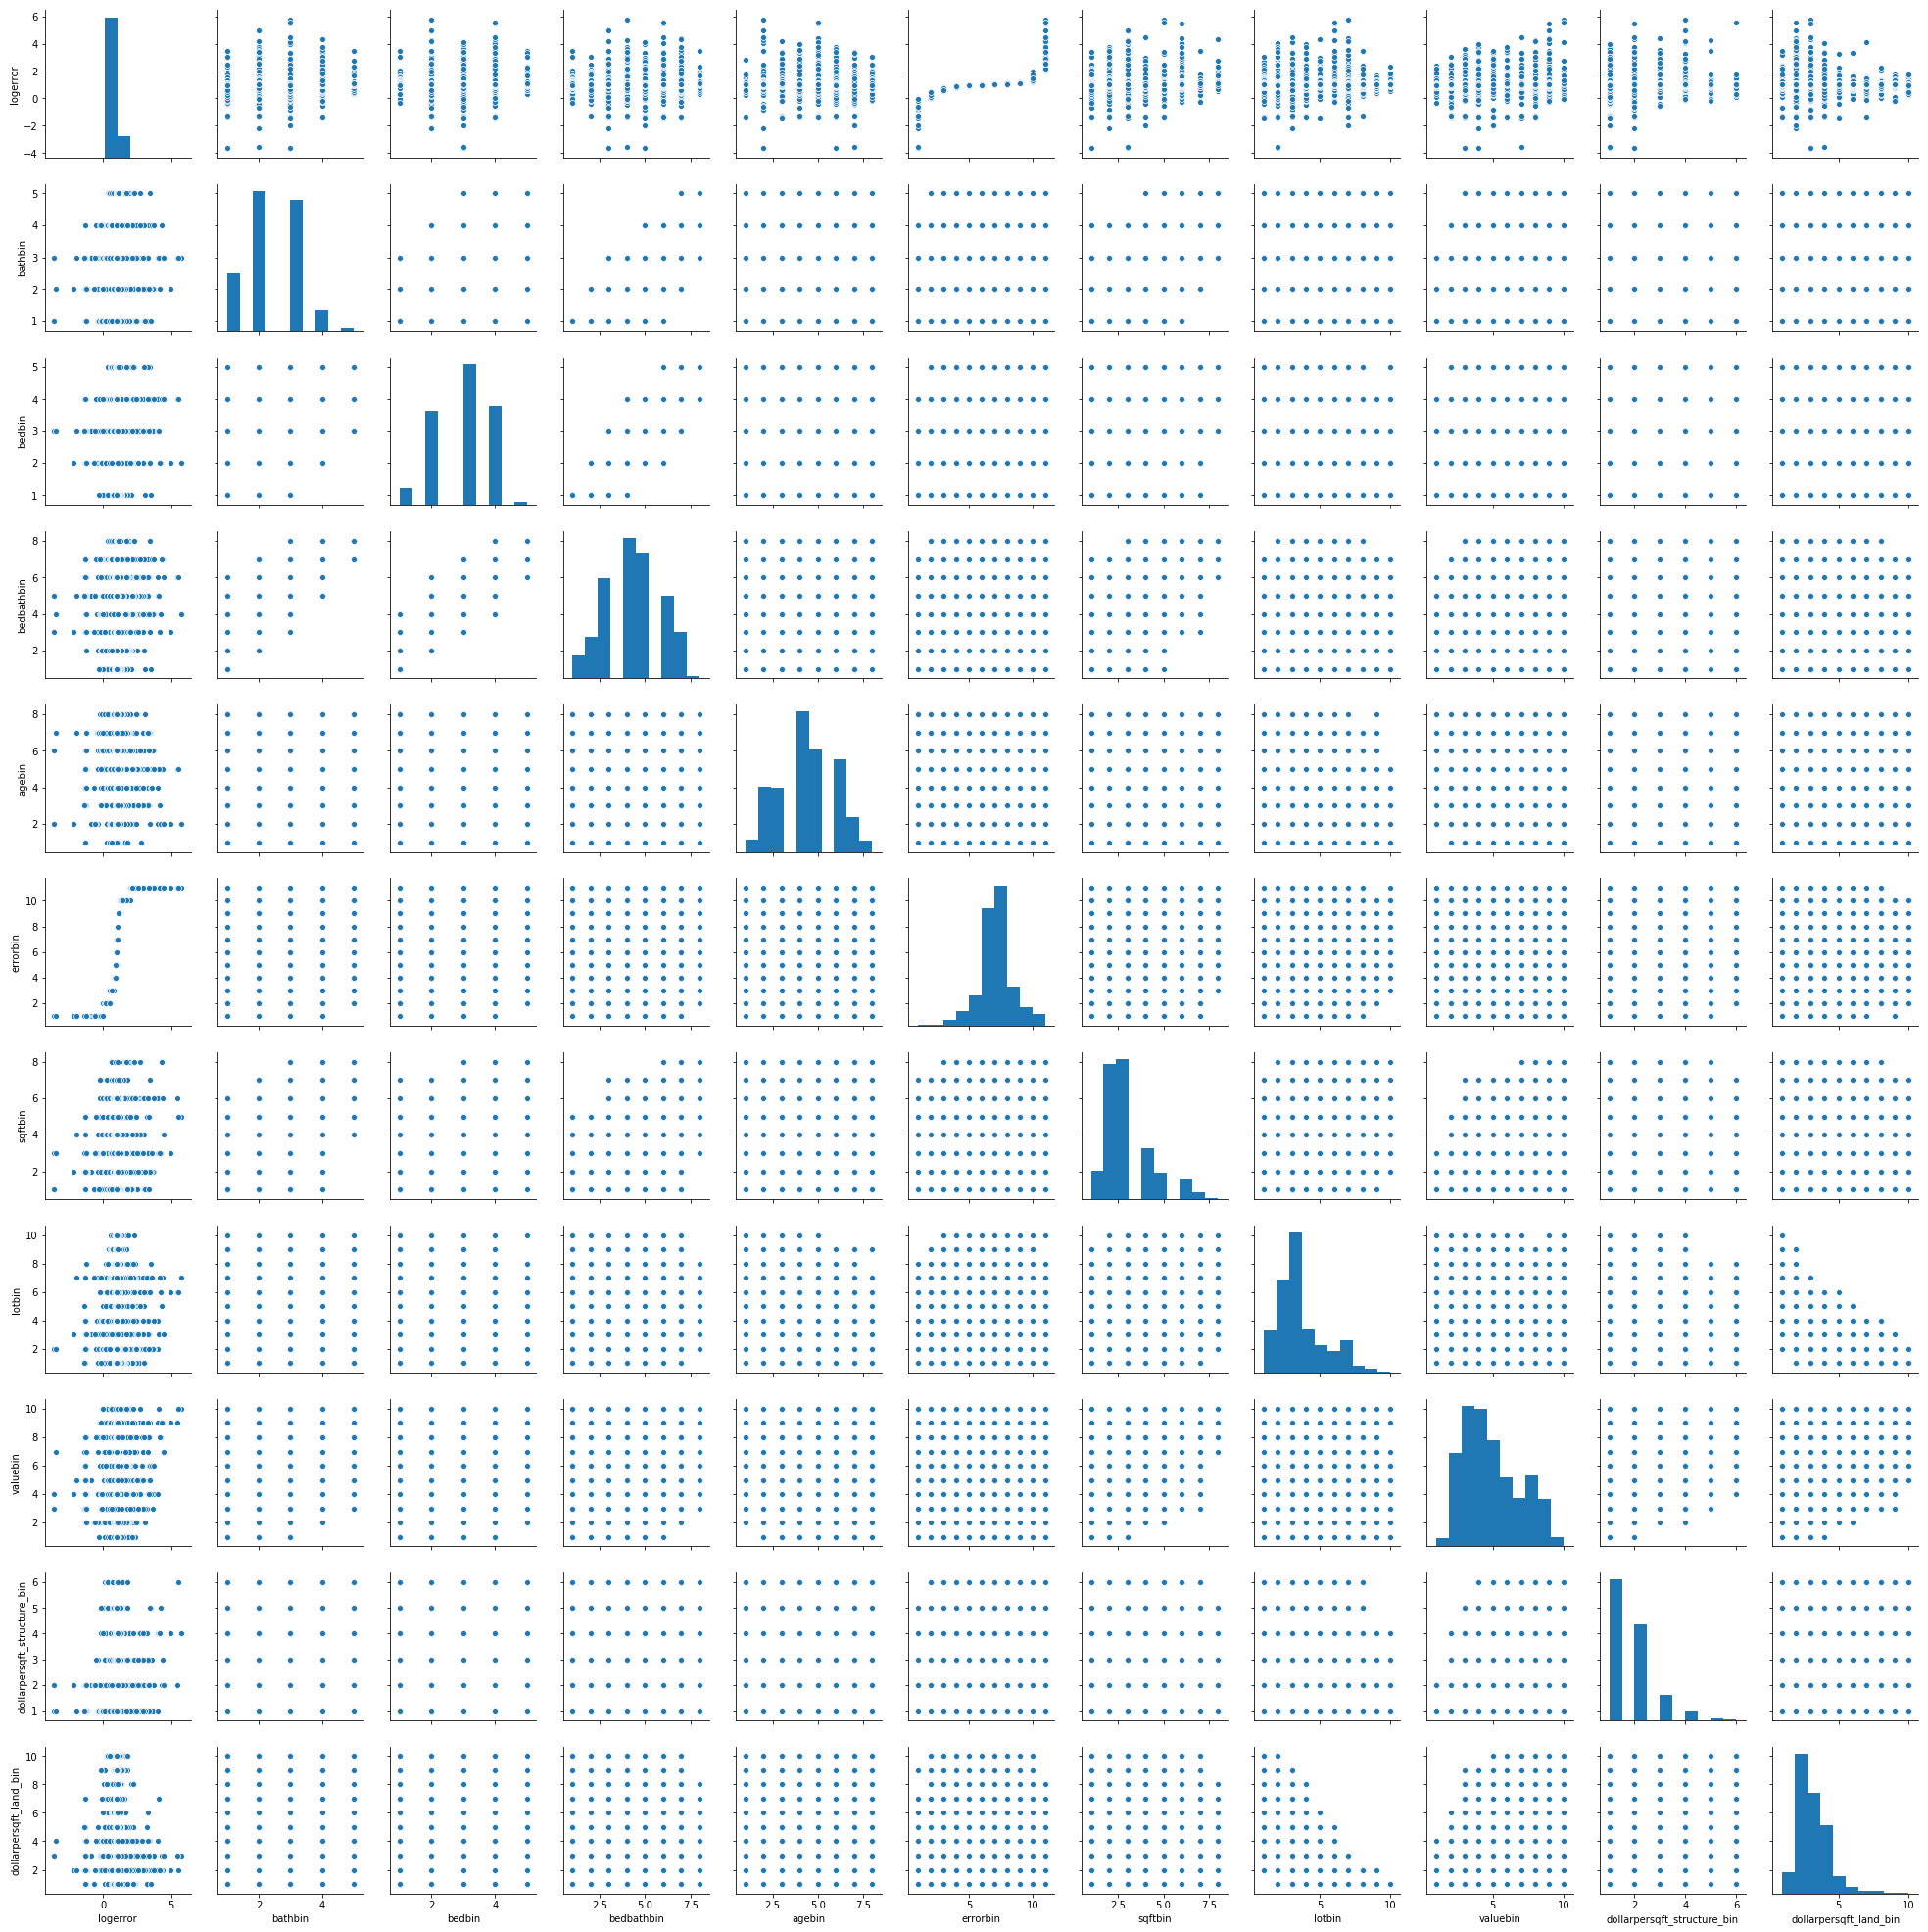

In [33]:
explore.pair_plot(df.drop(columns=['parcelid', 'regionidcounty', 
                                   'latitude', 'longitude']))

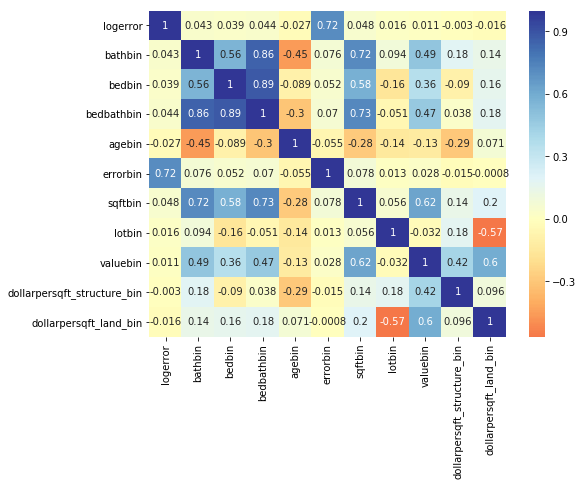

In [34]:
# plt.figure(figsize=(8,6))
explore.heat_map(df.drop(columns=['parcelid', 'regionidcounty',
                                  'latitude', 'longitude']))

Drop bathbin, bedbin as correlation with bedbathbin is .86, .89, and bedbathbin is more highly correlated with logerror than the other two.
Drop valuebin, as it has high correlation with sqftbin and sqftbin is more correlated with logerror.  

In [35]:
df.drop(columns=['bathbin','bedbin'], inplace=True)

Min Max Scaler

In [36]:
df.drop(columns=['parcelid'], inplace=True)
num_cols = df.drop(columns=['logerror','errorbin']).select_dtypes(include='number').columns

# create object
scaler = MinMaxScaler()

# fit & transform train
df[num_cols] = scaler.fit_transform(df[num_cols])

In [37]:
df.describe(include='all')

,latitude,longitude,regionidcounty,logerror,bedbathbin,agebin,errorbin,sqftbin,lotbin,valuebin,dollarpersqft_structure_bin,dollarpersqft_land_bin
count,69719.000000,69719.000000,69719.0,69719.000000,69719.000000,69719.000000,69719.000000,69719.000000,69719.000000,69719.000000,69719.000000,69719.000000
unique,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,3101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,43816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.453854,0.658729,NaN,1.010498,0.475847,0.484793,6.629771,0.287765,0.271367,0.426589,0.133238,0.214695
std,0.186925,0.200002,NaN,0.146881,0.218610,0.227808,1.325157,0.189714,0.205666,0.244273,0.168711,0.142529
min,0.000000,0.000000,NaN,-3.605000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.311293,0.535053,NaN,0.976700,0.285714,0.285714,6.000000,0.142857,0.111111,0.222222,0.000000,0.111111
50%,0.472135,0.675069,NaN,1.005000,0.428571,0.428571,7.000000,0.285714,0.222222,0.333333,0.000000,0.222222
75%,0.571581,0.819383,NaN,1.035850,0.571429,0.714286,7.000000,0.428571,0.333333,0.555556,0.200000,0.333333


In [52]:
db = DBSCAN(eps=0.015, min_samples=50, metric='euclidean', algorithm='auto')
df['labels'] = db.fit_predict(df[['longitude','latitude']])

# Orange County: (33.5, -117.7) (33.8, -118.0)
# LA County: (33.7, -118.7) (34.0, -118.1)
# Ventura County: (34.3, -119.3), (34.4, -119.5)

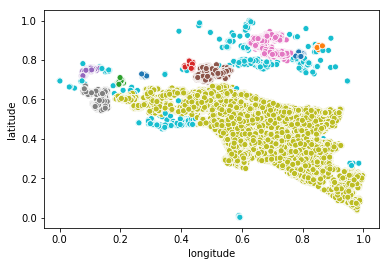

In [53]:
sns.scatterplot(df.longitude, df.latitude, hue=df.labels, 
                palette='tab10_r', legend=False)

In [ ]:
df.regionidcounty.value_counts()

In [ ]:
pd.crosstab(df.labels, df.regionidcounty)
# df.labels.value_counts()

In [ ]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df[['structure_dollarpersqft', 'taxvalue']])
    
    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)
    
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
km = MiniBatchKMeans(n_clusters=4, random_state=seed)
km.fit(df[['structure_dollarpersqft', 'taxvalue']])
df['dollarpersqft_labels'] = km.labels_

km.cluster_centers_

In [ ]:
pd.crosstab(df.dollarpersqft_labels, pd.qcut(df.logerror, 5))

Cluster 2 & 3 are shaped differently than the other 2.  It has more in the extremes of the logerror values.

Train Test Split

In [54]:
df.regionidcounty.value_counts()

3101.0    43816
1286.0    19587
2061.0     6316
Name: regionidcounty, dtype: int64

In [55]:
df_la = df[df.regionidcounty==3101]
X = df_la.drop(columns=['logerror','regionidcounty','errorbin'])
y = df_la.logerror

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=seed)

MSE:  0.02336231539534494 
r-squared:  0.006208151028513131


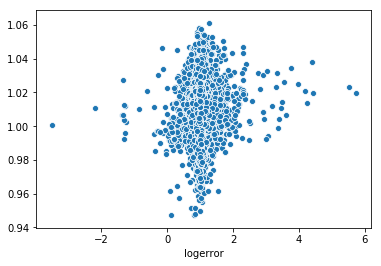

In [57]:
lr, coef, intercept, MAE, MSE, y_pred, scatter = model.linreg(X_train, y_train)
print("MSE: ", MSE, "\nr-squared: ", r2_score(y_train, y_pred))

MSE:  0.0233623155082634 
r-squared:  0.006208146225160194


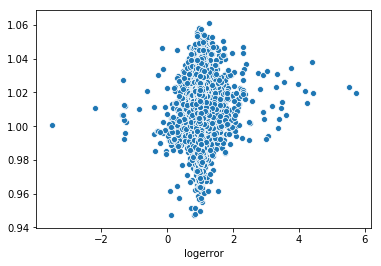

In [58]:
rr, coef, intercept, MAE, MSE, y_pred, scatter = model.ridge(X_train, y_train)
print("MSE: ", MSE, "\nr-squared: ", r2_score(y_train, y_pred))

In [59]:
svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly = model.svm(X_train, y_train)
print("MSE rbf: ", MSE_rbf, "\nMSE lin: ",  MSE_lin, "\nMSE poly: ", MSE_poly)

MSE rbf:  0.02320254419230209 
MSE lin:  0.02342335862204278 
MSE poly:  0.023260881745075238


In [ ]:
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X_train, y_train).predict(X_train), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X_train[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [ ]:
sns.scatterplot(y, y_pred)

MSE:  0.01570422505026732 
r-squared:  0.003914095604153789
MSE:  0.015704225688456697 
r-squared:  0.00391405512514631
MSE rbf:  0.015723251082504542 
MSE lin:  0.015849821021719442 
MSE poly:  0.015724551360967502


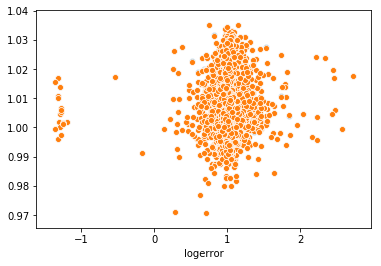

In [60]:
df_or = df[df.regionidcounty==1286]
X = df_or.drop(columns=['logerror','regionidcounty','errorbin'])
y = df_or.logerror

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=seed)

lr, coef, intercept, MAE, MSE, y_pred, scatter = model.linreg(X_train, y_train)
print("MSE: ", MSE, "\nr-squared: ", r2_score(y_train, y_pred))

rr, coef, intercept, MAE, MSE, y_pred, scatter = model.ridge(X_train, y_train)
print("MSE: ", MSE, "\nr-squared: ", r2_score(y_train, y_pred))

svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly = model.svm(X_train, y_train)
print("MSE rbf: ", MSE_rbf, "\nMSE lin: ",  MSE_lin, "\nMSE poly: ", MSE_poly)

MSE:  0.015910110774758908 
r-squared:  0.0076847111096897125
MSE:  0.015910136583844426 
r-squared:  0.007683101394300729
MSE rbf:  0.01540623555740573 
MSE lin:  0.016000561552044292 
MSE poly:  0.015660453514239423


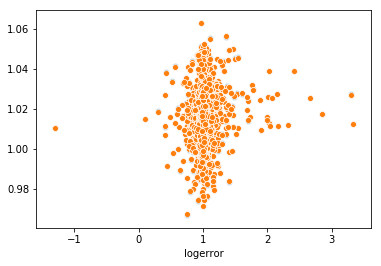

In [61]:
df_vn = df[df.regionidcounty==2061]
X = df_vn.drop(columns=['logerror','regionidcounty','errorbin'])
y = df_vn.logerror

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=seed)

lr, coef, intercept, MAE, MSE, y_pred, scatter = model.linreg(X_train, y_train)
print("MSE: ", MSE, "\nr-squared: ", r2_score(y_train, y_pred))

rr, coef, intercept, MAE, MSE, y_pred, scatter = model.ridge(X_train, y_train)
print("MSE: ", MSE, "\nr-squared: ", r2_score(y_train, y_pred))

svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly = model.svm(X_train, y_train)
print("MSE rbf: ", MSE_rbf, "\nMSE lin: ",  MSE_lin, "\nMSE poly: ", MSE_poly)
